# Space Titanic Kaggle Competition

## Introduction

This notebook is a submission for the Space Titanic Kaggle competition.

**Goal**: Predict whether the passenger was transported to another dimension based on the features provided.

## Import Libraries

In [269]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


## Data Exploration and Visualization

In [270]:
data_og = pd.read_csv('spaceship_titanic_data/train.csv')
data = data_og.copy()

Quick look at the data.

In [271]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [272]:
def describe_dataset(df: pd.DataFrame) -> None:
    # Ensure full output is displayed
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)

    print("="*40)
    print("🔍 Dataset Overview")
    print("="*40)

    print("\n📌 Data Types:")
    print(df.dtypes.to_string())

    print("\n📌 Number of Rows and Columns:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\n📌 Duplicate Rows:")
    print(df.duplicated().sum())

    print("\n📌 Missing Values:")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
    print(missing_df[missing_df['Missing Values'] > 0].to_string())

    print("\n📌 Summary Statistics (Numerical Features):")
    print(df.describe().to_string())

    print("\n📌 Summary Statistics (Categorical Features):")
    print(df.describe(include=['O']).to_string())

    print("="*40)


In [273]:
describe_dataset(data)

🔍 Dataset Overview

📌 Data Types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool

📌 Number of Rows and Columns:
Rows: 8693, Columns: 14

📌 Duplicate Rows:
0

📌 Missing Values:
              Missing Values  Percentage
HomePlanet               201    2.312205
CryoSleep                217    2.496261
Cabin                    199    2.289198
Destination              182    2.093639
Age                      179    2.059128
VIP                      203    2.335212
RoomService              181    2.082135
FoodCourt                183    2.105142
ShoppingMall             208    2.392730
Spa                      183    2.105142
VRDeck                   188    2.162660
Name                     200    2.300702

📌

Conclusions:
- Convert data types (str - bool) and extract relevant information from raw features (id -> travelled as group).
- There are no duplicate records.
- There are missing values, about 2% in case of the features affected -> Impute missing values.
- There seem to be extreme values in the bills relative to the mean, check with graphs.
- There are no missing values in the target variable.
- The remaining categorical features have a reasonable number of unique values, so we can use one-hot encoding.
- There are passengers with the same name, do a check if they are not the same person.

Separate the columns into numerical and categorical for the sake of plotting.

In [274]:
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
identifiers = ['PassengerId', 'Name']
target = 'Transported'

### Visualizations

#### Numerical Features

In [275]:
def plot_feature_distribution(data, feature, y_scale='normal'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Apply log1p transformation if needed
    transformed_feature = np.log1p(data[feature]) if y_scale == 'log' else data[feature]

    # Boxplot
    sns.boxplot(y=transformed_feature, ax=axes[0])
    axes[0].set_title(f'Boxplot of {feature} ({y_scale} scale)')
    axes[0].set_ylabel(f'{feature} (log scale)' if y_scale == 'log' else feature)

    # Histogram
    sns.histplot(y=transformed_feature, kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram of {feature} ({y_scale} scale)')
    axes[1].set_ylabel(f'{feature} (log scale)' if y_scale == 'log' else feature)

    plt.tight_layout()
    plt.show()


In [276]:
def plot_feature_distribution_split(data, feature, y_scale='normal'):
    plot_df = data.copy()  
    zero_count = (plot_df[feature] == 0).sum()
    non_zero_data = plot_df[plot_df[feature] > 0]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    sns.barplot(x=['Zero', 'Non-Zero'], y=[zero_count, len(non_zero_data)], ax=axes[0])
    axes[0].set_title(f'Zero vs. Non-Zero Counts ({feature})')
    axes[0].set_ylabel('Count')

    if y_scale == 'log':
        non_zero_data.loc[:, feature] = np.log1p(non_zero_data[feature]) 

    sns.boxplot(data=non_zero_data, y=feature, ax=axes[1])
    axes[1].set_title(f'Boxplot of Non-Zero {feature}')
    axes[1].set_ylabel(f'{"Log(1 + " + feature + ")" if y_scale == "log" else feature}')

    sns.histplot(non_zero_data, y=feature, kde=True, ax=axes[2])
    axes[2].set_title(f'Histogram of Non-Zero {feature}')
    axes[2].set_ylabel(f'{"Log(1 + " + feature + ")" if y_scale == "log" else feature}')

    plt.tight_layout()
    plt.show()


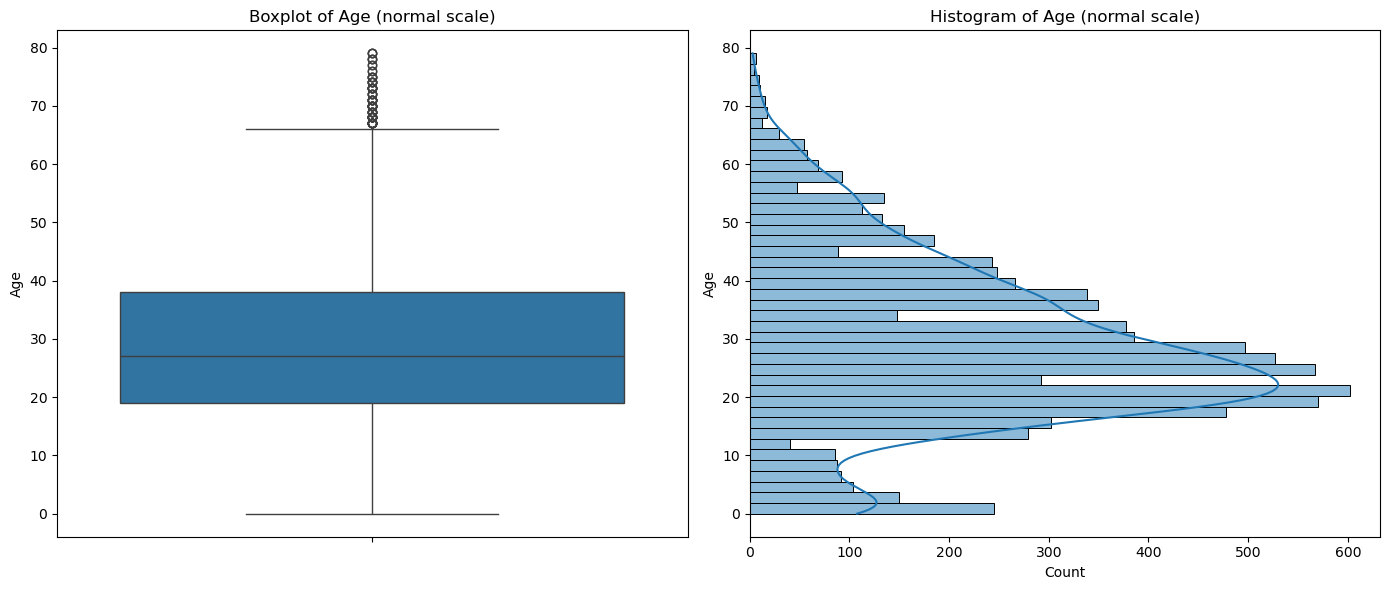

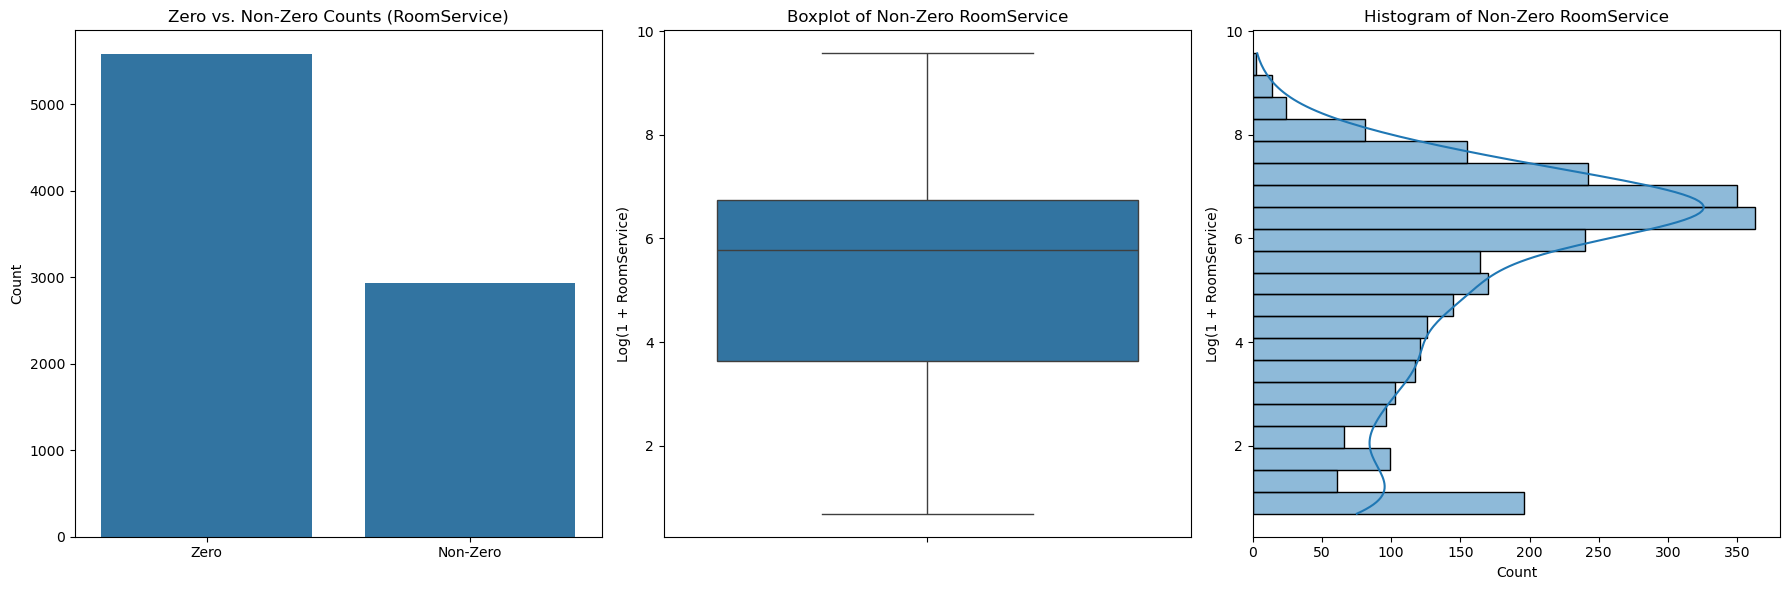

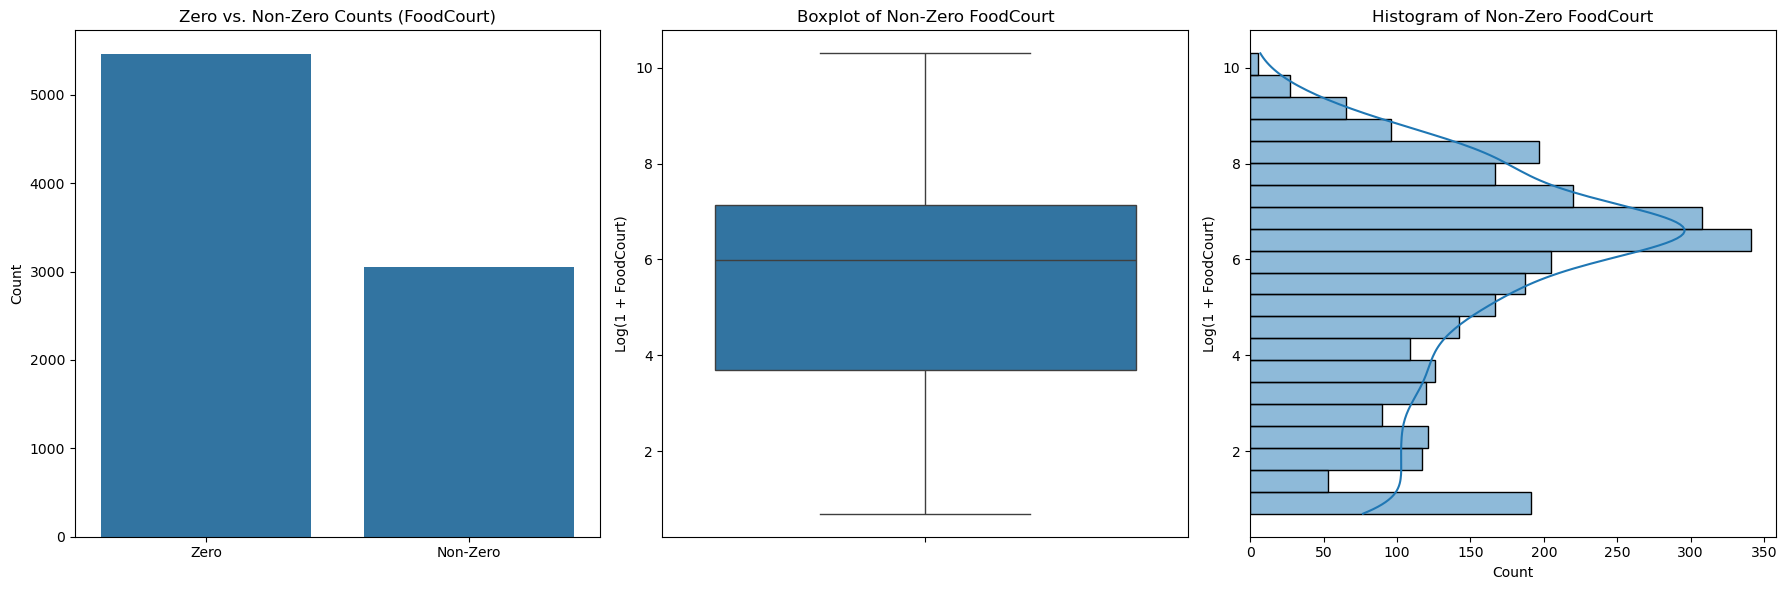

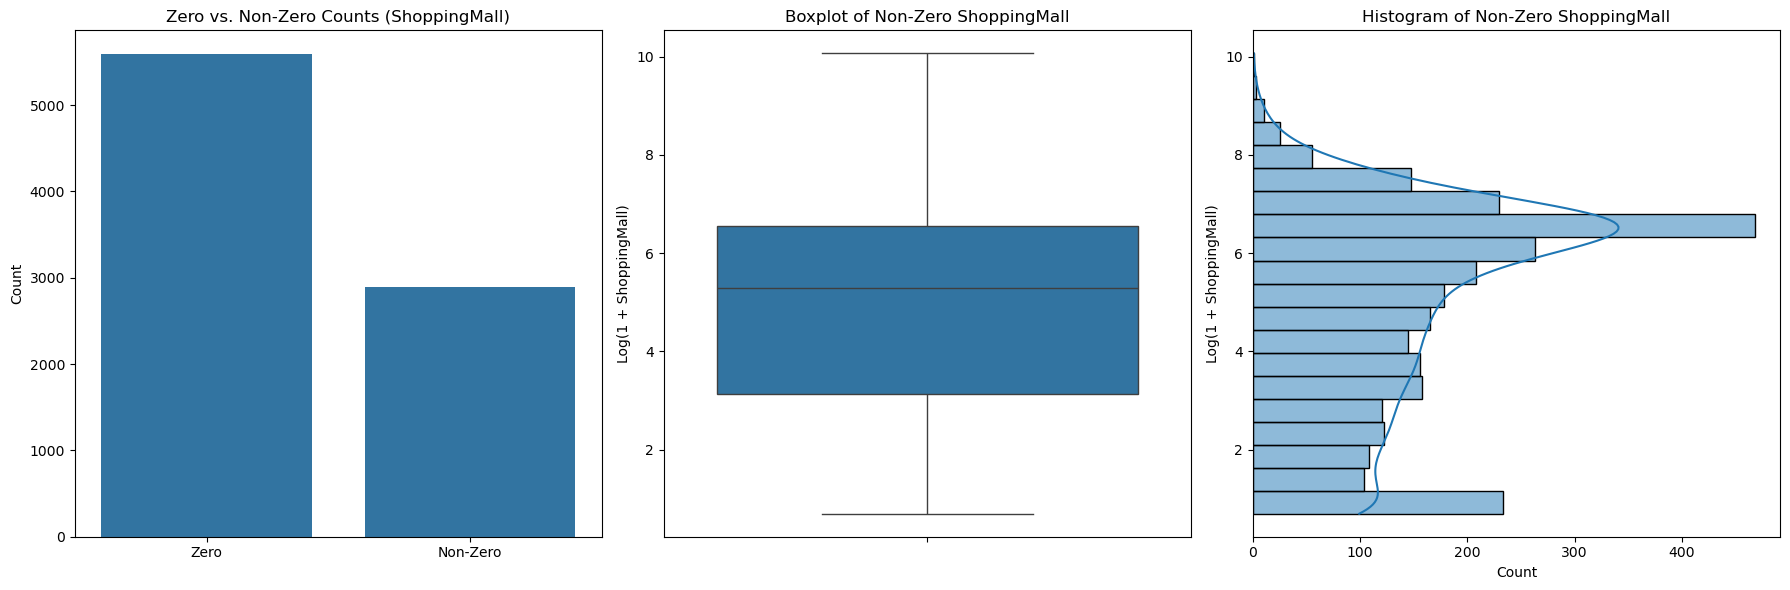

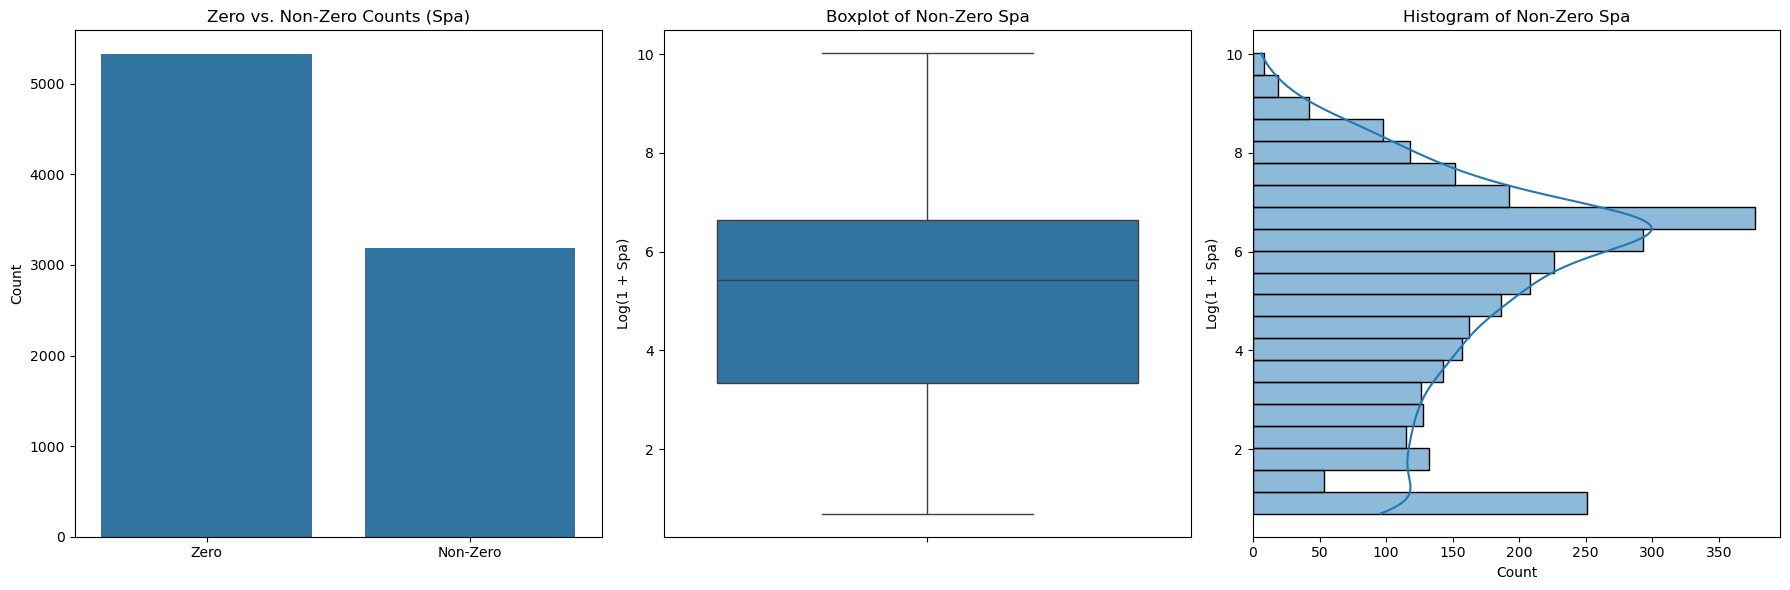

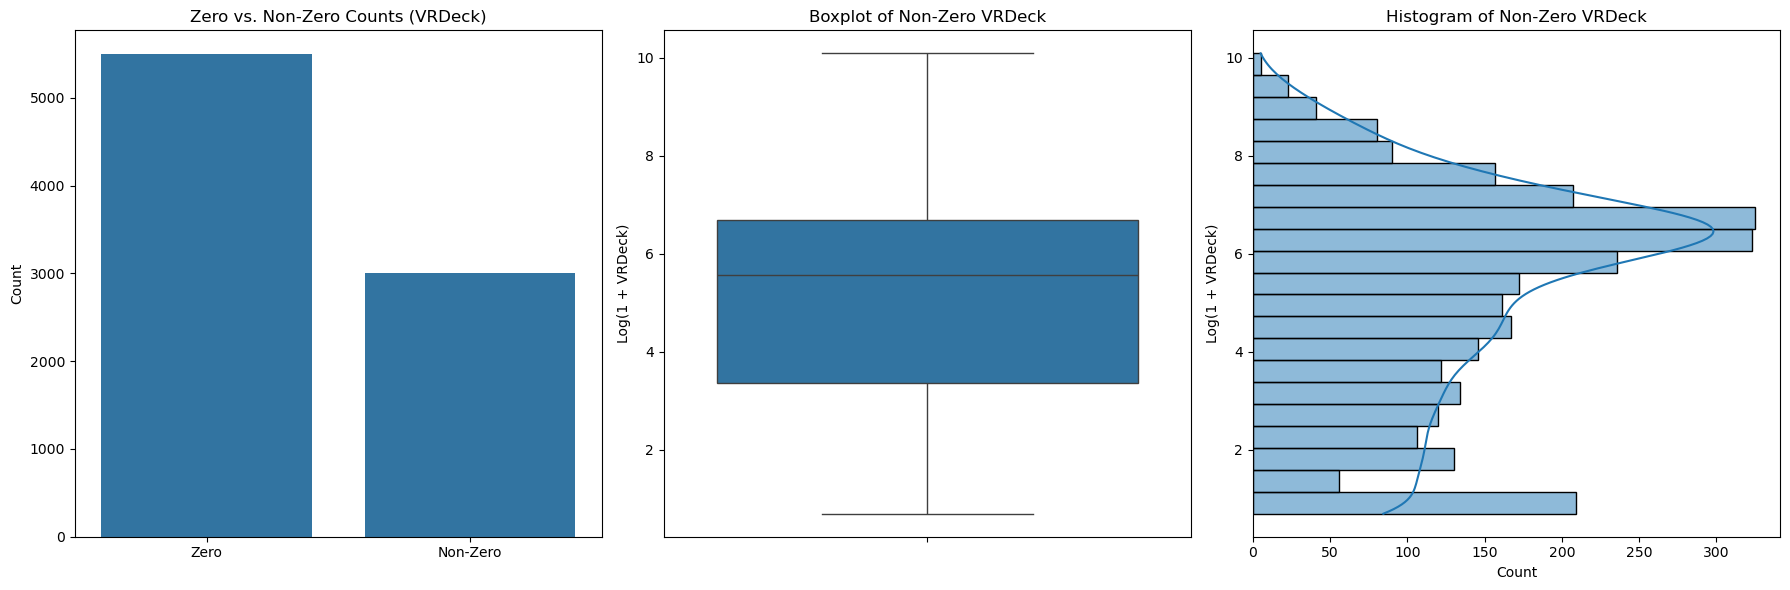

In [277]:
plot_feature_distribution(data, 'Age')

for feature in [f for f in num_features if f != 'Age']:
    plot_feature_distribution_split(data, feature=feature, y_scale='log')

As the spending columns are highly skewed, I used log transform them to make them easier to display.

I also decided to display the proportion of non-spenders in each category, as they also have a significant effect on the feature being skewed.

##### Conclusions:

I will not remove any outliers from these columns, as they are likely to be real data, we do not have further information on the unit or the context of the records that would suggest otherwise.

Later on scaling will be necessary.

#### Categorical features

In [278]:
def plot_categorical_distributions(data, cat_features, target):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    axes = axes.flatten()

    for i, feature in enumerate(cat_features + [target]):
        data[feature].value_counts().plot.pie(
            autopct=lambda p: f'{p:.1f}%\n({int(p * len(data) / 100)})', 
            startangle=90, 
            counterclock=False, 
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_ylabel('')

    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

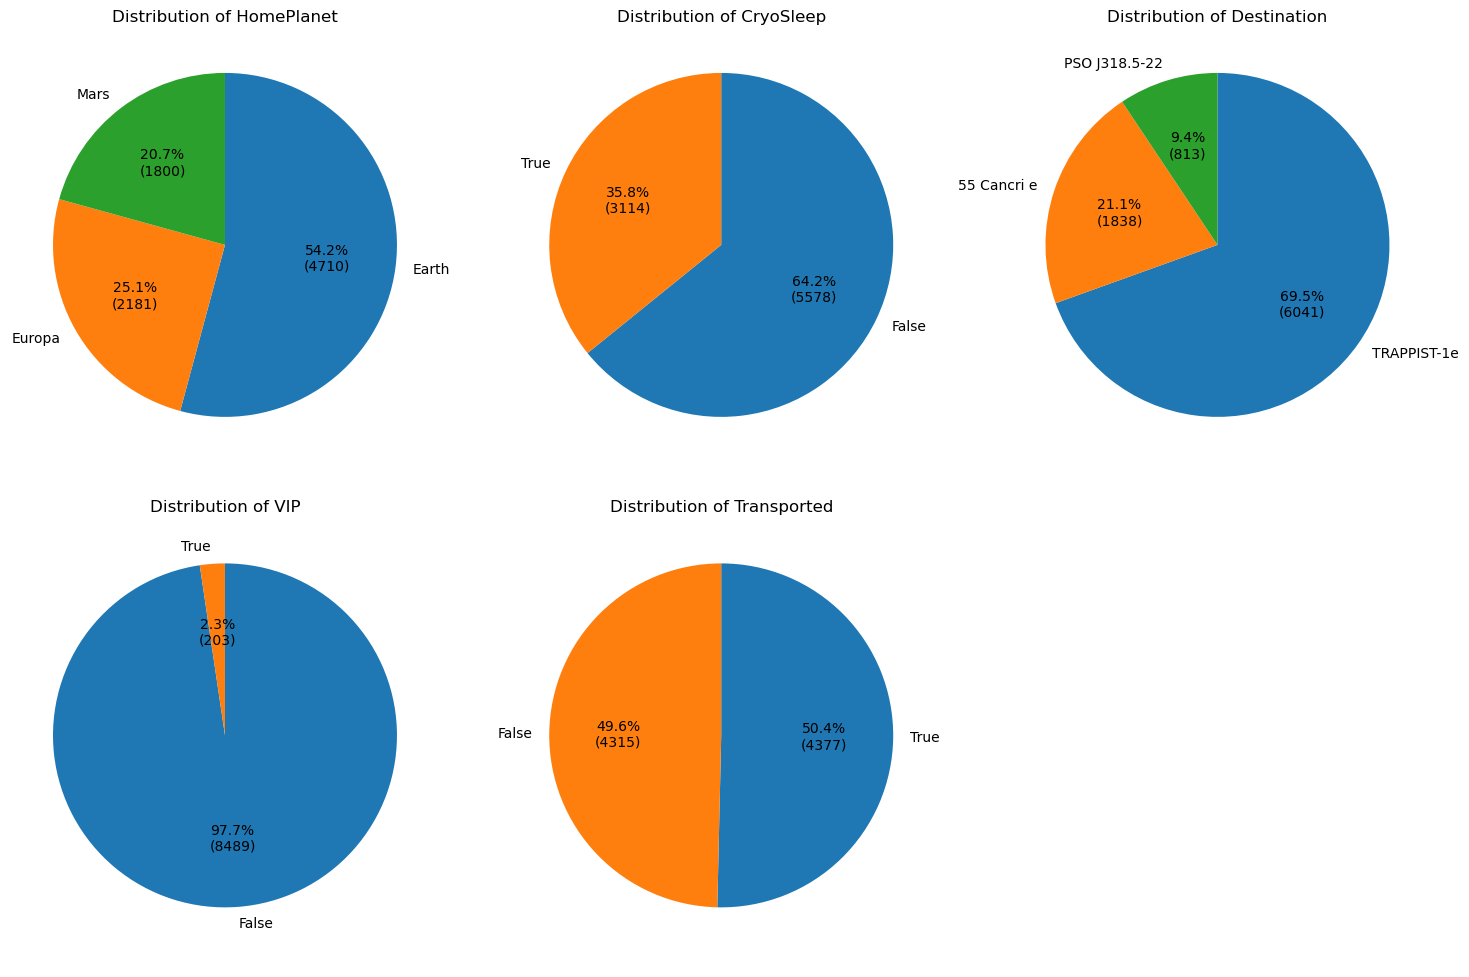

In [279]:
plot_categorical_distributions(data, cat_features, target)


##### Conclusions:
- The VIP feature is imbalanced - as expected.
- The other categorical features are reasonably distributed among the classes.
- The target is well balanced - good news!

#### Correlation Matrix

Plotting the correlation matrix to see if there are any strong correlations between the numerical features.

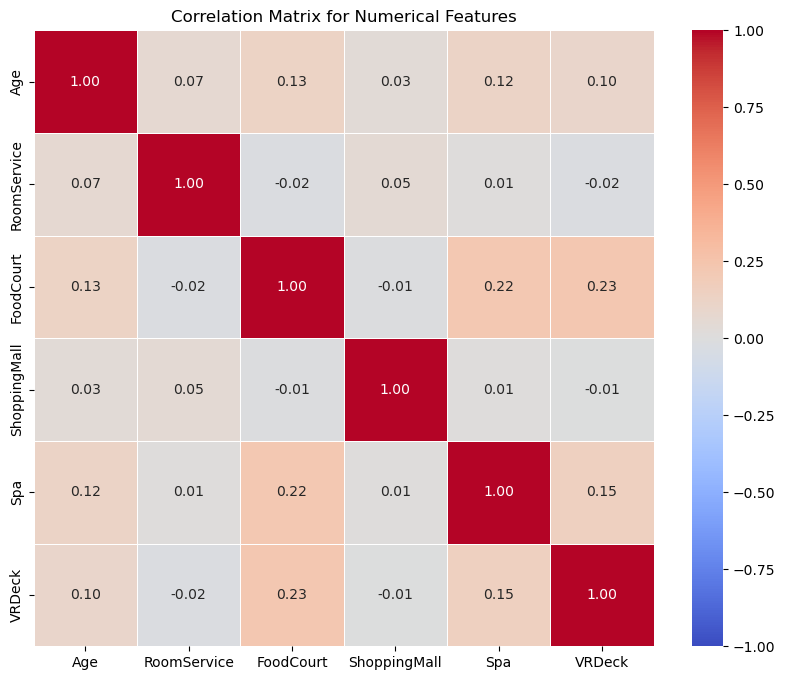

In [280]:
corr_matrix = data[num_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Features')
plt.show()

There doesn't seem to be any strong correlations between the numerical features.

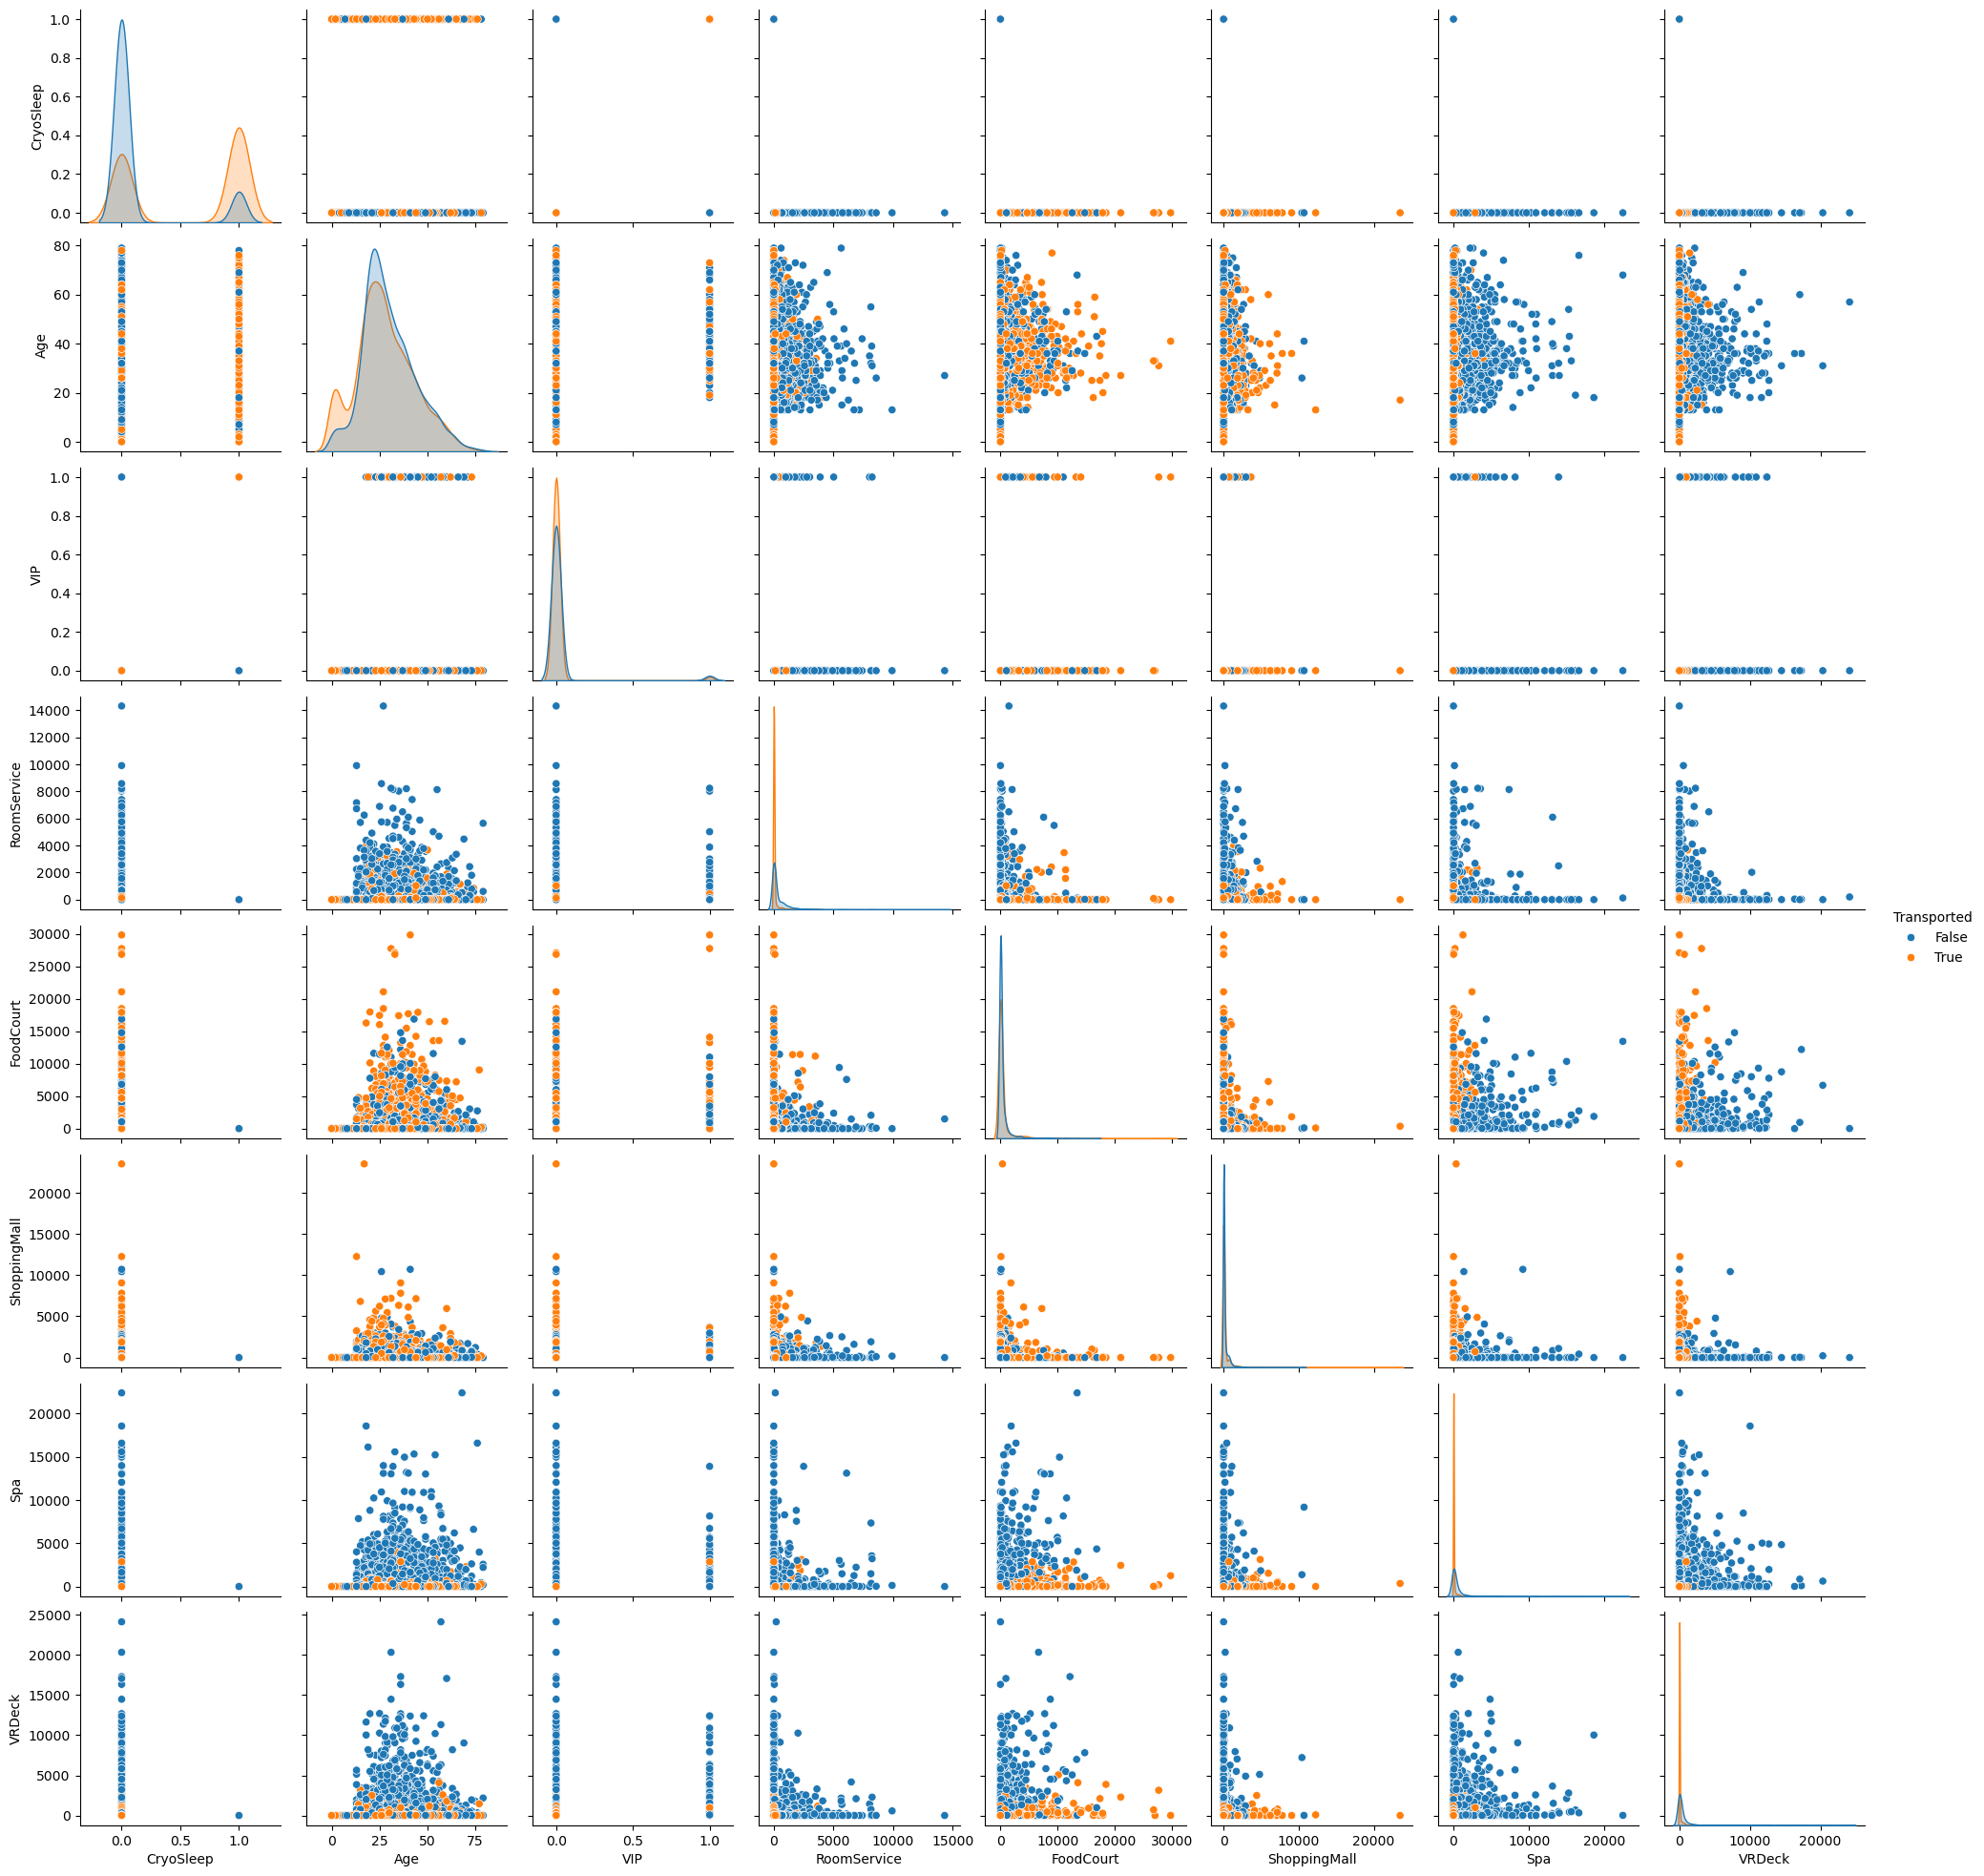

In [281]:
sns.pairplot(data, hue=target, diag_kind='kde')

##### Conclusions:

- From the plots it is a visible tendency that the passangers that spent less on `Spa`, `RoomService`, and `VRDeck` were more likely to be transported to another dimension.

#### Checking cabin and target correlation

To check if the physical layout of the ship has a connection to the target variable, I will check the proportion of passengers transported to another dimension in the certain cabins.

In [282]:
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    return df.drop(columns=['Cabin'])

In [283]:
cabin_df = split_cabin(data)[['Deck', 'Num', 'Side', 'VIP', 'Transported']]
cabin_df_encoded = cabin_df.copy()


In [284]:
categorical_features = cabin_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_features:
    cabin_df_encoded[col] = cabin_df_encoded[col].astype('category').cat.codes  


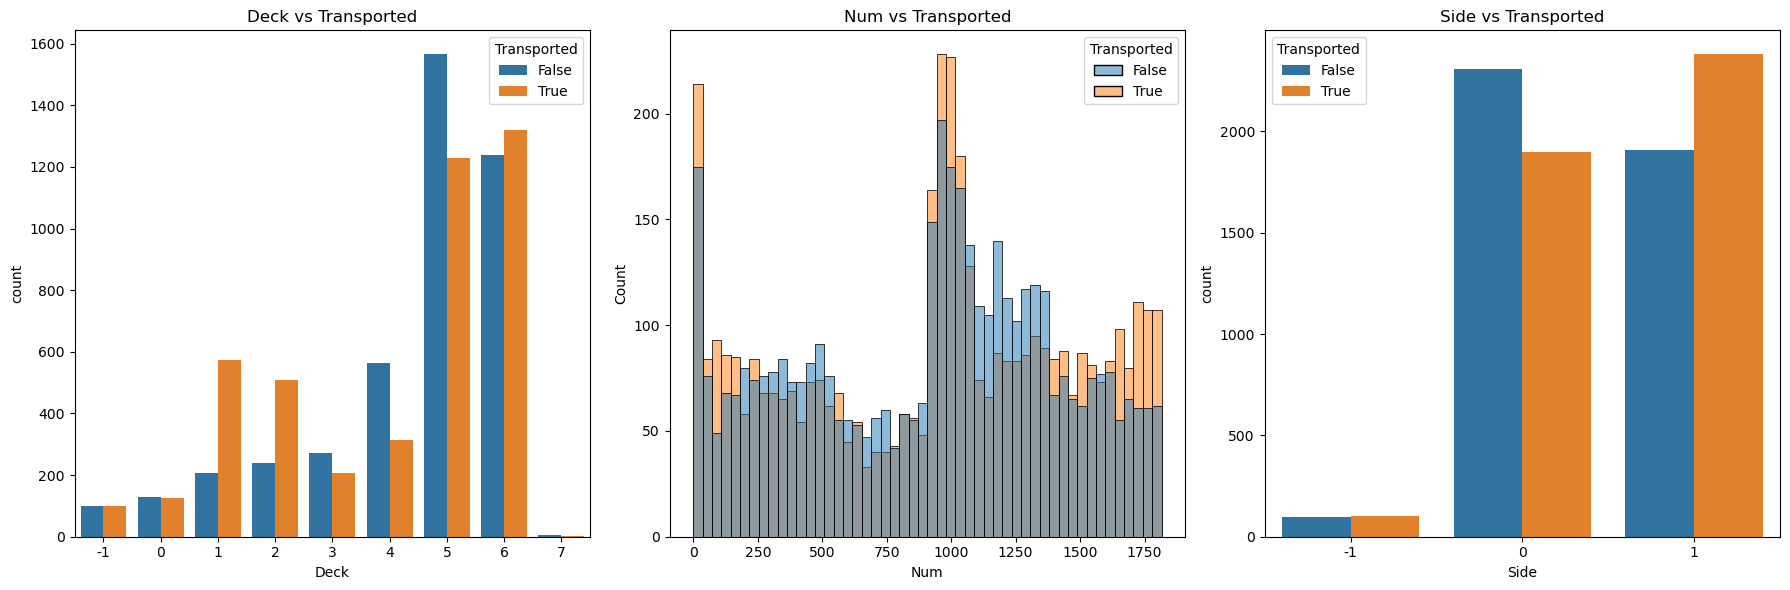

In [285]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.countplot(x='Deck', data=cabin_df_encoded, hue='Transported', ax=axes[0])
axes[0].set_title('Deck vs Transported')

sns.countplot(x='Side', data=cabin_df_encoded, hue='Transported', ax=axes[2])
axes[2].set_title('Side vs Transported')

sns.histplot(x='Num', data=cabin_df_encoded, hue='Transported', bins=50, ax=axes[1])
axes[1].set_title('Num vs Transported')

plt.tight_layout()
plt.show()

##### Conclusions:
- There is a significant difference in the proportion of passengers transported to another dimension from Deck 1 and Deck 2, and also negatively from Deck 4 and Deck 5.
- The number of the room seems to have a connection to the target, but it is not as clear as the deck.
- The side of the ship does not seem to have a significant effect on the target variable.

#### Checking duplicate names validity

In [286]:
double_names = data[data['Name'].isin(data['Name'].value_counts()[data['Name'].value_counts() > 1].index)].sort_values(by = 'Name')

In [287]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

def jaccard_similarity(row1, row2, categorical_cols):
    """Compute Jaccard similarity between two categorical records."""
    matches = sum(row1[col] == row2[col] for col in categorical_cols)
    return matches / len(categorical_cols)

def compute_pairwise_similarity(group, numeric_cols, categorical_cols, num_weight=0.7, cat_weight=0.3):
    """Compute similarity for all pairs within a group (only records with the same Name)."""
    if len(group) < 2:
        return None  # Skip if only one record with that Name

    similarities = []
    
    # Ensure numerical columns have no NaNs (fill with median of the group)
    group.loc[:, numeric_cols] = group[numeric_cols].fillna(group[numeric_cols].median())

    # Generate all possible pairs within the group
    for (idx1, row1), (idx2, row2) in combinations(group.iterrows(), 2):
        # Compute cosine similarity for numerical features
        num_vector1 = row1[numeric_cols].values.reshape(1, -1)
        num_vector2 = row2[numeric_cols].values.reshape(1, -1)
        num_sim = cosine_similarity(num_vector1, num_vector2)[0][0]  # Extract single similarity value

        # Compute Jaccard similarity for categorical features
        cat_sim = jaccard_similarity(row1, row2, categorical_cols)

        # Compute final similarity score
        final_sim = (num_sim * num_weight) + (cat_sim * cat_weight)

        similarities.append({
            'Name': row1['Name'],  # Keep track of which Name these belong to
            'Index1': idx1, 'Index2': idx2,
            'Numerical_Similarity': num_sim,
            'Categorical_Similarity': cat_sim,
            'Final_Similarity': final_sim
        })

    return pd.DataFrame(similarities)


In [288]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [289]:
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']

filtered_data = data[data.duplicated('Name', keep=False)]  
similarity_results = filtered_data.groupby('Name', group_keys=False).apply(
    compute_pairwise_similarity, numeric_features, categorical_features, 
).reset_index(drop=True)

In [290]:
for name in similarity_results['Name'].unique():
    double_names.loc[double_names['Name'] == name, 'similarity'] = similarity_results.loc[similarity_results['Name'] == name, 'Final_Similarity'].values[0]

double_names.sort_values(by = 'similarity', ascending = False)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,similarity
8002,8560_01,Earth,True,G/1391/P,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,Glena Hahnstonsen,True,G,1391,P,0.925000
6702,7073_01,Earth,True,G/1161/S,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,NaN,Glena Hahnstonsen,True,G,1161,S,0.925000
2559,2746_01,Mars,False,F/569/P,TRAPPIST-1e,52.0,False,758.0,0.0,356.0,5.0,0.0,Apix Wala,False,F,569,P,0.751251
4108,4387_01,Mars,False,F/902/P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,18.0,0.0,Apix Wala,False,F,902,P,0.751251
4730,5050_01,Earth,False,F/1028/P,TRAPPIST-1e,31.0,False,433.0,111.0,238.0,86.0,0.0,Loree Wolfernan,False,F,1028,P,0.408804
7650,8164_01,Earth,False,G/1314/S,TRAPPIST-1e,31.0,False,0.0,918.0,0.0,0.0,900.0,Loree Wolfernan,False,G,1314,S,0.408804
6987,7429_01,Mars,False,NaN,TRAPPIST-1e,38.0,False,1126.0,0.0,23.0,34.0,0.0,Cuses Pread,False,NaN,NaN,NaN,0.348246
6171,6513_01,Mars,False,F/1244/S,TRAPPIST-1e,20.0,False,57.0,0.0,1185.0,0.0,0.0,Cuses Pread,False,F,1244,S,0.348246
220,0234_01,Earth,False,F/50/P,TRAPPIST-1e,43.0,False,NaN,888.0,0.0,0.0,0.0,Keitha Josey,False,F,50,P,0.333857
5432,5808_01,Earth,False,G/934/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Keitha Josey,False,G,934,P,0.333857


After checking the duplicate names using additional similarity scores and the features, the passengers are not the same person as they are staying in different cabins in different groups.

It is an interesting discrepancy, as some of the passengers are even the same age from the same planet.

As we had a reasonable amount of matching names, we could check by hand, but in case of a bigger load we can rely on the similarity scores. 

## Feature Engineering

### Cleaning and imputing the existing features

Actions to take:
- Count number of passengers in the group
- Drop the `PassengerId` column -> create bool feature of travelling in group or not
- Drop the `Name` column
- Split `Cabin` into `Deck`/`Num`/`Side`
- `Age`: impute missing values with median
- Impute missing values in the billing columns `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` with 0 if the passenger is in `CryoSleep`, else with the median
- Create `TotalBill` feature from the sum of the billing columns
- If `CryoSleep` is missing, impute with False if the passenger has bills, True otherwise
- Convert bool features represented as strings to bool: `CryoSleep`, `VIP`
- Impute mode for `HomePlanet`, `Destination`

As I will have to do the same modifications to the test data, I will do it in a pipeline.

In [291]:
def process_groups(df):
    df = df.copy()
    df['GroupSize'] = df.groupby(df['PassengerId'].str.split('_').str[0])['PassengerId'].transform('count')
    df['InGroup'] = df['GroupSize'] > 1
    return df.drop(columns=['PassengerId'])

def drop_name(df):
    """Drops the 'Name' column."""
    return df.drop(columns=['Name'], errors='ignore')

def split_cabin(df):
    """Splits the 'Cabin' column into 'Deck', 'Num', and 'Side'."""
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    return df.drop(columns=['Cabin'])

def impute_cryosleep(df):
    """Infers 'CryoSleep' based on billing columns."""
    billing_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['CryoSleep'] = df['CryoSleep'].fillna(df[billing_cols].sum(axis=1) == 0)
    return df

def impute_billing(df):
    """Imputes missing billing values based on 'CryoSleep' status."""
    billing_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    df.loc[df['CryoSleep'], billing_cols] = 0  

    df[billing_cols] = df[billing_cols].fillna(df[billing_cols].median())

    return df

def sum_billing(df):
    """Creates a 'TotalBill' column as the sum of all billing-related columns."""
    billing_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalBill'] = df[billing_cols].sum(axis=1)
    return df

def convert_bool(df):
    """Converts 'CryoSleep' and 'VIP' columns to boolean dtype."""
    df[['CryoSleep', 'VIP']] = df[['CryoSleep', 'VIP']].astype('boolean')
    return df


In [292]:
custom_prep_pipeline = Pipeline([
    ('process_groups', FunctionTransformer(process_groups)),
    ('drop_name', FunctionTransformer(drop_name)),
    ('split_cabin', FunctionTransformer(split_cabin)),
    ('impute_cryosleep', FunctionTransformer(impute_cryosleep)),
    ('impute_billing', FunctionTransformer(impute_billing)),
    ('sum_billing', FunctionTransformer(sum_billing)),
    ('convert_bool', FunctionTransformer(convert_bool))
])

In [293]:
preprocessed_data = pd.DataFrame(custom_prep_pipeline.fit_transform(data))

In [294]:
preprocessed_data.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck',
       'Num', 'Side', 'GroupSize', 'InGroup', 'TotalBill'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Define features
num_features = ['Age']
log_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalBill']
cat_features = ['HomePlanet', 'Destination', 'Deck', 'Side',]
room_feature = ['Num']  

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Log-transformation pipeline
log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column transformer
transformer = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('log', log_pipeline, log_features),
    ('cat', cat_pipeline, cat_features)
])

# Full pipeline
final_pipeline = Pipeline([
    ('preprocessing', custom_prep_pipeline),
    ('transformer', transformer),
])

transformed_data = final_pipeline.fit_transform(data)

encoder = final_pipeline.named_steps['transformer'].named_transformers_['cat'].named_steps['encoder']
cat_feature_names = encoder.get_feature_names_out(cat_features)

all_columns = num_features + log_features + list(cat_feature_names)

final_preprocessed_data = pd.DataFrame(transformed_data, columns=all_columns)


In [296]:
final_preprocessed_data.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalBill,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0.711945,-0.638181,-0.650080,-0.622995,-0.664035,-0.640034,-1.152845,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.334037,1.090491,0.135040,0.646081,1.614565,0.745894,0.636892,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2.036857,0.753511,2.139858,-0.622995,2.518191,0.784254,1.353979,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.293552,-0.638181,1.790516,1.682500,2.264863,1.277886,1.165307,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.891895,1.464342,0.803380,1.333879,1.624920,-0.240051,0.743469,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Model Building

In [299]:
X = final_preprocessed_data
y = data['Transported']

In [301]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logistic_regression_model = LogisticRegression(random_state=42)

logistic_regression_model.fit(X, y)

LogisticRegression(random_state=42)

In [309]:
test_data = pd.read_csv('spaceship_titanic_data/test.csv')

X_test = pd.DataFrame(final_pipeline.transform(test_data), columns=all_columns)

In [310]:
X_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalBill,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,-0.124841,-0.638181,-0.650080,-0.622995,-0.664035,-0.640034,-1.152845,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.682698,-0.638181,0.135040,-0.622995,2.205344,-0.640034,1.001884,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.154088,-0.638181,-0.650080,-0.622995,-0.664035,-0.640034,-1.152845,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.642213,-0.638181,2.351447,-0.622995,1.215205,1.680362,1.262841,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.612966,0.243681,-0.650080,1.891398,-0.664035,-0.640034,0.601169,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [311]:
logistic_regression_model.predict(X_test)

array([ True, False,  True, ...,  True,  True,  True])